In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import dates
import pymc3 as pm
import arviz as az
plt.style.use('Solarize_Light2')
%matplotlib inline

/Users/roysu001/opt/anaconda3/lib/python3.8/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jan 07 2021

Python implementation: CPython
Python version       : 3.8.2
IPython version      : 7.16.1

seaborn   : 0.11.1
matplotlib: 3.2.2
numpy     : 1.18.5
pandas    : 1.0.5

Watermark: 2.1.0



Exercise
*Please use Python 

The attached CSV file lists the customer, date, and dollar value of orders placed at a store in 2017. The actual gender and predicted gender of each customer is also provided.

Complete each of the following activities in a jupyter notebook using Python. Send back only your notebook file and please do not zip it. Please do not exclude $0 orders.

 

A) Assemble a dataframe with one row per customer and the following columns:

* customer_id * gender * most_recent_order_date * order_count (number of orders placed by this customer)

Sort the dataframe by customer_id ascending and display the first 10 rows.

B) Plot the count of orders per week for the store.

C) Compute the mean order value for gender 0 and for gender 1. Do you think the difference is significant? Justify your choice of method.

D) Generate a confusion matrix for the gender predictions of customers in this dataset. You should assume that there is only one gender prediction for each customer. What does the confusion matrix tell you about the quality of the predictions?

E) Describe one of your favorite tools or techniques and give a small example of how it's helped you solve a problem. Limit your answer to one paragraph, and please be specific.

For each question, state any considerations or assumptions you made. 

## A) Assemble a dataframe with one row per customer and the following columns:
- customer_id * gender * most_recent_order_date * order_count (number of orders placed by this customer)
- Sort the dataframe by customer_id ascending and display the first 10 rows.

In [3]:
df_data = pd.read_csv('screening_exercise_orders_v201810.csv')
df_data.head(n=1)

,customer_id,gender,date,value,predicted_gender
0,1000,0,2017-01-01 00:11:31,198.5,1


In [4]:
df_data_to_work = df_data.copy()
df_data_to_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13471 entries, 0 to 13470
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       13471 non-null  int64  
 1   gender            13471 non-null  int64  
 2   date              13471 non-null  object 
 3   value             13471 non-null  float64
 4   predicted_gender  13471 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 526.3+ KB


In [5]:
df_data_to_work['date'] = pd.to_datetime(df_data_to_work.date)
display(df_data_to_work.info())

grouped_customer_id = df_data_to_work.groupby('customer_id') 

assert grouped_customer_id.filter(lambda x: len(np.unique(x['gender'])) > 1).shape[0] == 0
assert grouped_customer_id.filter(lambda x: len(np.unique(x['predicted_gender'])) > 1).shape[0] == 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13471 entries, 0 to 13470
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       13471 non-null  int64         
 1   gender            13471 non-null  int64         
 2   date              13471 non-null  datetime64[ns]
 3   value             13471 non-null  float64       
 4   predicted_gender  13471 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 526.3 KB


None

In [6]:
df_data_to_work_agg = df_data_to_work.groupby(by = ['customer_id','gender']).agg(
    most_recent_order_date=pd.NamedAgg(column='date', aggfunc='max'),
    order_count=pd.NamedAgg(column='date', aggfunc='count')).reset_index()

df_data_to_work_agg.sort_values(by = ['customer_id'],inplace=True)
df_data_to_work_agg.head(n=10)

,customer_id,gender,most_recent_order_date,order_count
0,1000,0,2017-01-01 00:11:31,1
1,1001,0,2017-01-01 00:29:56,1
2,1002,1,2017-02-19 21:35:31,3
3,1003,1,2017-04-26 02:37:20,4
4,1004,0,2017-01-01 03:11:54,1
5,1005,1,2017-12-16 01:39:27,2
6,1006,1,2017-05-09 15:27:20,3
7,1007,0,2017-01-01 15:59:50,1
8,1008,0,2017-12-17 05:47:48,3
9,1009,1,2017-01-01 19:27:17,1


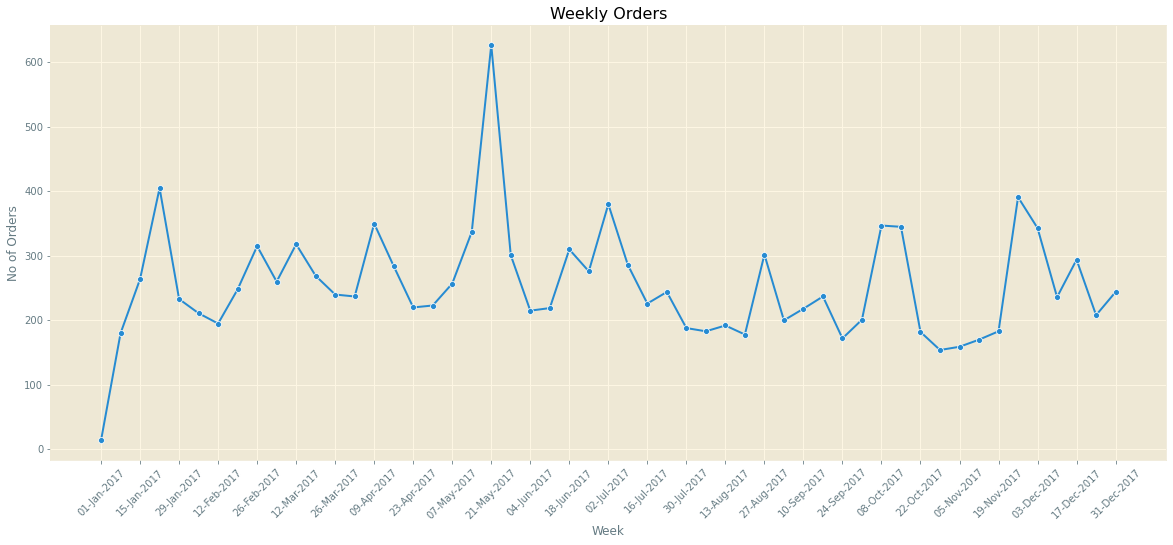

In [7]:
df_to_plot = df_data_to_work.set_index( ['date']).resample('W').agg({'customer_id':'size'}).reset_index()
fig,axs = plt.subplots(1,1, figsize = (20,8))
sns.lineplot(data= df_to_plot, x = 'date', y = 'customer_id',marker = 'o')
axs.set_title('Weekly Orders')
axs.set_xlabel('Week')
axs.set_xticklabels(df_to_plot.date.values[::2], rotation= 45)
axs.set(xticks=df_to_plot.date.values[::2])
axs.xaxis.set_major_formatter(dates.DateFormatter("%d-%b-%Y"))
axs.set_ylabel('No of Orders')
plt.show()

In [8]:
df_data_to_work_agg_value = df_data_to_work.groupby(by = ['customer_id','gender']).agg(
    total_value=pd.NamedAgg(column='value', aggfunc='sum')).reset_index()

df_data_to_work_agg_value.groupby(by = ['gender']).agg(
    mean_value=pd.NamedAgg(column='total_value', aggfunc='mean')).reset_index()

,gender,mean_value
0,0,558.096789
1,1,534.139896


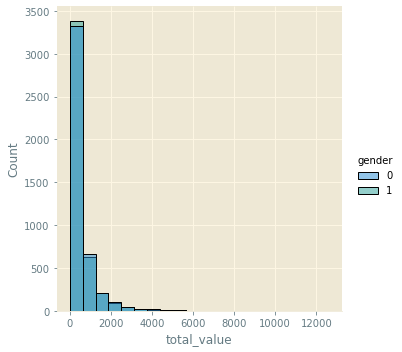

In [13]:
sns.displot(df_data_to_work_agg_value,x="total_value", hue="gender",bins=20 )

In [32]:
y0 = df_data_to_work_agg_value[df_data_to_work_agg_value.gender == 0].total_value.values
y1 = df_data_to_work_agg_value[df_data_to_work_agg_value.gender == 1].total_value.values
mu_m = df_data_to_work_agg_value.total_value.mean()
mu_s = df_data_to_work_agg_value.total_value.std() * 2
sigma_low = 1
sigma_high = 100

with pm.Model() as mean_model:
    group0_mean = pm.Normal("group0_mean", mu=mu_m, sd=mu_s)
    group1_mean = pm.Normal("group1_mean", mu=mu_s, sd=mu_s)
    group0_std = pm.Uniform("group1_std", lower=sigma_low, upper=sigma_high)
    group1_std = pm.Uniform("group2_std", lower=sigma_low, upper=sigma_high)
    nu = pm.Exponential("nu_minus_one", 1 / 29.0) + 1
    lambda0 = group0_std ** -2
    lambda1 = group1_std ** -2
    group0 = pm.StudentT("group0", nu=nu, mu=group0_mean, lam = lambda0, observed=y1)
    group1 = pm.StudentT("group1", nu=nu, mu=group1_mean, lam=lambda1, observed=y1)
    diff_of_means = pm.Deterministic("difference of means", group0_mean - group1_mean)
    trace = pm.sample(1000, tune =1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_one, group2_std, group1_std, group1_mean, group0_mean]
Sampling 4 chains, 0 divergences:   1%|▏         | 108/8000 [03:38<4:26:20,  2.02s/draws]


ValueError: Not enough samples to build a trace.